
**Pending questions:**

- student-t distribution for autocorrelated timeseries ?
- does the chi square prediction of the sample variance distribution holds with autocorrelated timeseries ?
- is bootstrap approaches valid for autocorrelated timeseries in order to estimate confidence intervals on the mean and variance?
- between subsampling, theoretical estimates given an estimate of the effective degrees of freedom, bootstrap, are there guidelines for what is more performant and when?


# mean, variance

"Back to basics" (but not so basic in the details):

- How can we estimate the mean and variance of an autocorrelated timeseries?
- What are associated confidence intervals?

### references:

- Bendat and Piersol: *J. S. Bendat and A. G. Piersol. Random Data: Analysis and Measurement Procedures. Wiley series in probability and statistics. Wiley-Interscience, 3rd edition, 2000.*
- Bailey and Hammersley 1946 - general timeseries, sample mean and variance : *G. Bayley and J. Hammersley. The” effective” number of independent observations in an autocorrelated time series. Supplement to the Journal of the Royal Statistical Society, 8(2):184–197, 1946.*
- Zieba 2010: *A. Zieba. Effective number of observations and unbiased estimators of variance for autocorrelated data-an overview. Metrology and Measurement Systems, (1), 2010.*
- Barlett 1946 - long time series, autocorrelations: *M. S. Bartlett. On the theoretical specification and sampling properties of autocorrelated time-series. Supplement to the Journal of the Royal Statistical Society, 8(1):27–41, 1946.*
- Chelton 1983 - multivariate case, cross-correlations: *D. B. Chelton. Effects of sampling errors in statistical estimation. Deep Sea Research Part A. Oceano- graphic Research Papers, 30(10):1083–1103, 1983.*

--- 

## general background

We are interested in computing the mean and variance of a variable $u$:

$
\begin{align}
\mu &= \big \langle u \big \rangle, \\
\sigma_0 &= \big \langle (u-\mu)^2 \big \rangle
\end{align}
$

$\sigma_0$ may be refered to as the "stationary variance", i.e. the signal variance in the absence of instrumental noise. \
This random variable is further described by an autocorrelation function:

$
\begin{align}
\sigma(\tau) &= \big \langle [ u(t+\tau) - \mu] [u(t)-\mu] \big \rangle
\end{align}
$

#### Estimations

The sample mean and variance are defined by: 

$
\begin{align}
\hat\mu &= \frac{1}{N} \sum_n u_n, \\
\hat \sigma_0 &= \frac{1}{N-1} \sum_n ( u_n - \hat \mu )^2
\end{align}
$

Note that this expression of the sample variance is biased for autocorrelated timeseries.

--- 

## mean

- $\hat\mu$ is an unbiased estimator of the average of the signal.
- the variance of $\hat\mu$ is given by: 

$
\begin{align}
Var(\hat\mu) &= \big \langle (\hat \mu - \mu)^2  \big \rangle, \\
&= \big \langle \hat \mu ^2  \big \rangle - \mu^2, \\
&= \frac{1}{N^2} \sum_{n,m} \big \langle u_n u_m  \big \rangle - \mu^2, \\
&= \frac{1}{N^2} \sum_{n,m} \big \langle (u_n-\mu) (u_m-\mu) \big \rangle, \\
&= \frac{1}{N^2} \sum_{n,m} \sigma(n-m),
\end{align}
$

- For autocorrelated time series (no assumption about the distribution required), we may thus define an "effective number of independent observations" (or "degrees of freedom") $N_e$, such that: $Var(\hat\mu) = \sigma_0 / N_e$. An expression for $N_e$ is obtained by equating both expression of the sample mean variance:

$
\begin{align}
Var(\hat\mu) &= \frac{1}{N^2} \sum_{n,m} \sigma(n-m) = \frac{\sigma_0}{N_e}, \\
N_e &= \frac{N^2}{\sum_{n,m} \sigma(n-m)/\sigma_0}. 
\end{align}
$

- If $u$ is a Gaussian normal variable, so will be the sample mean with mean $\mu$ and the variance indicated above.
- For independent data, the central limit theorem (CLT) states that the distribution of the sample average asymptotically converges towards a normal distribution with mean $\mu$ and variance $\sigma_0/N$, even if the data is not normally distributed.
- (expected distribution) for a normally distributed timeseries, the following variable is distributed as a student t distribution with $N_e$ (to be checked, this guessed from the uncorrelated case).

$
\begin{align}
t &= \frac{\hat\mu - \mu}{\sqrt{\hat \sigma_0/N_e}}
\end{align}
$

---
## generate synthetic data

Generate a 100 day time series with an exponential autocorrelation and a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

Input parameters:

In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
dt = 3/24 # hours, sampling interval

In [4]:
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=5000, 
                         seed=0,
                        ).compute()

# total number of points
N = u.time.size # = delta_T/dt 


## mean: DOF

# Effective number of points (effective degrees of freedom)
Neff_rough = delta_T/T # rough estimate, turns out to be twice too large

# exact
_t = u.time.values
Neff_exact = N**2/np.sum(np.exp(-abs(_t[:, None] - _t[None, :])/T)[:])

# Bayley and Hammersley 1946: eq 14 - but form of paragraph 4, see also Barlett 1946
Neff_bh = N/(1+2*np.sum((1 - _t/_t[-1])*np.exp(-abs(_t-_t[0])/T)))

# AR(1), a = np.exp(-dt/T)
Neff_bretherton = N * (1 - np.exp(-dt/T)) / (1 + np.exp(-dt/T))
# https://atmos.uw.edu/~breth/classes/AS552/lect/lect03.pdf

print("mean - DOF (Neff):")

print(f"  rough: delta_T / T = {Neff_rough} ")
print(f"  exact: {Neff_exact:.1f}")
print(f"  bretherton: {Neff_bretherton:.1f}")
print(f"  bayley and hammersley: {Neff_bh:.1f}")

mean - DOF (Neff):
  rough: delta_T / T = 10.0 
  exact: 5.6
  bretherton: 5.0
  bayley and hammersley: 5.5


In [5]:
## variance (see cells below for explanations): scale correction and DOF

# correction factor for the sample variance to be unbiased (Bailey and Hammersley)
sigma_correction = Neff_exact * (N-1) /N /(Neff_exact-1)
Neff_var = N * (1 - np.exp(-2*dt/T)) / (1 + np.exp(-2*dt/T))

print("variance:")
print(f" correction factor = {sigma_correction:.2f}")
print(f"  DOF = {Neff_var:.1f}")

variance:
 correction factor = 1.22
  DOF = 10.0


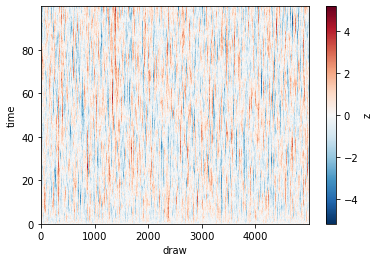

In [6]:
u.plot()

Compute sample mean and variance:

In [7]:
ds = u.mean("time").rename("mu_hat").to_dataset()
ds["mu_hat_var"] = ds["mu_hat"].var()

ds["sigma0_hat"] = u.var("time")*sigma_correction
ds["sigma0_hat_var"] = ds["sigma0_hat"].var() 

In [8]:
print(f"Overall mean and std : {float(u.mean()):.2e},  {float(u.std()):.2f}")

Overall mean and std : 3.75e-03,  0.98


---
## mean

### verifies the distribution of the sample mean

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1.5)

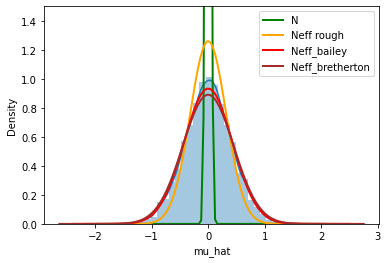

In [9]:
ax = sns.distplot(ds.mu_hat, bins=30, norm_hist=True)

def add_dist(Neff, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.norm.pdf(x_pdf, loc=mu, scale=sigma0/np.sqrt(Neff), )
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

add_dist(N, "N", "green")
add_dist(Neff_rough, "Neff rough", "orange")
add_dist(Neff_bh, "Neff_bailey", "red")
add_dist(Neff_bretherton, "Neff_bretherton", "brown")
    
ax.legend()

ax.set_ylim(0, 1.5)

The observed vs predicted standard deviations are:

In [10]:
print(f"observed sqrt(Var(mu_hat)) = {float(np.sqrt(ds.mu_hat_var)):.3f}")
print(f"predicted with N : {np.sqrt(sigma0/N):.3f}")
print(f"predicted with Neff rough : {np.sqrt(sigma0/Neff_rough):.3f}")
print(f"predicted with Neff_exact : {np.sqrt(sigma0/Neff_exact):.3f}")
print(f"predicted with Neff_bailey : {np.sqrt(sigma0/Neff_bh):.3f}")
print(f"predicted with Neff_bretherton : {np.sqrt(sigma0/Neff_bretherton):.3f}")

observed sqrt(Var(mu_hat)) = 0.412
predicted with N : 0.035
predicted with Neff rough : 0.316
predicted with Neff_exact : 0.424
predicted with Neff_bailey : 0.427
predicted with Neff_bretherton : 0.447


### verifies the t-distribution

For a normally distributed timeseries, the distribution of the following variable follows a student t distribution:

$
\begin{align}
t &= \frac{\hat\mu - \mu}{\sqrt{\hat \sigma_0/N_e}}
\end{align}
$

Note that we used the rescaled version of the variance to account for the autocorrelation of the signal. \
Not doing so does make a difference in the comparison with the theoretical distribution.


/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


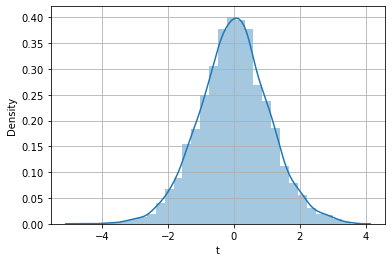

In [11]:
ds["t"] = (ds.mu_hat - mu)/np.sqrt(ds.sigma0_hat/Neff_exact)

ax = sns.distplot(ds.t, bins=30, norm_hist=True)
ax.grid()

The number of degrees of freedom of the student distribution does not make a huge visual difference. \
Not using the expression of the sample variance corrected with the autocorrelation factor does lead to visual difference (mentioned two cells above, not shown).

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


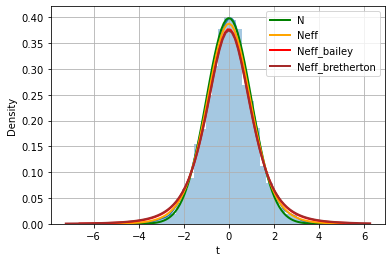

In [12]:
ax = sns.distplot(ds.t, bins=30, norm_hist=True)

def add_dist(Neff, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.t.pdf(x_pdf, Neff-1, loc=0, scale=1)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

add_dist(N, "N", "green")
add_dist(Neff_rough, "Neff", "orange")
add_dist(Neff_bh, "Neff_bailey", "red")
add_dist(Neff_bretherton, "Neff_bretherton", "brown")
    
ax.legend()
ax.grid()

#ax.set_ylim(0, 1.)

### confidence intervals

Confidence intervals are derived from the t distribution:

$
\begin{align}
t_{\alpha/2} 
< \frac{\hat\mu - \mu}{\sqrt{\hat \sigma_0/N_e}} 
< t_{1-\alpha/2},
\end{align}
$

where $t_{\alpha/2}$ and $t_{1-\alpha/2}$ are the $\alpha/2$ and $1-\alpha/2$ percentiles of the t distribution.
The following confidence interval is then given by:

$
\begin{align}
\hat\mu - t_{1-\alpha/2} \sqrt{\hat \sigma_0/N_e}  < \mu < \hat\mu - t_{\alpha/2} \sqrt{\hat \sigma_0/N_e} 
\end{align}
$

**Does bootstrap applies to autocorrelated time-series?**

In [13]:
def generate_CI(Ne, alpha=0.1):

    ds["mu_upper"] = ds.mu_hat - stats.t.ppf(alpha/2, Ne)*np.sqrt(ds.sigma0_hat/Ne)
    ds["mu_lower"] = ds.mu_hat - stats.t.ppf(1-alpha/2, Ne)*np.sqrt(ds.sigma0_hat/Ne)

    _ds = ds.sortby("mu_hat")

    fig, ax = plt.subplots(1,1)

    # not working ... ?
    #ax.fill_between(_ds.mu_lower.values, _ds.mu_upper.values)
    #ax.fill_between(_ds.mu_upper.values, _ds.mu_lower.values)

    ax.axhline(mu, label="truth")
    
    ax.plot(_ds.mu_lower, "0.5", lw=2, label=f"{alpha/2} lower bound")
    ax.plot(_ds.mu_upper, "0.5", lw=2, label=f"{1-alpha/2} upper bound")

    ax.plot(_ds.mu_hat, "k", lw=2, label="sample mean")
    ax.grid()
    ax.legend()

    # N = delta_T/dt*24

    percent_success = (_ds
                       .where( (_ds.mu_upper>mu) & (_ds.mu_lower<mu), drop=True )
                       .draw.size
                       /_ds.draw.size
                      )
    
    print(f"percent success = {percent_success:.2f}")

Below, the success rate is about right but a bit higher than what is predicted by theory. \
**Is this coming from the fact the student-t distribution is not correct for autocorrelated timeseries?**

percent success = 0.93


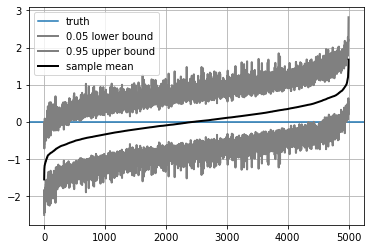

In [14]:
generate_CI(Neff_exact)

percent success = 0.95


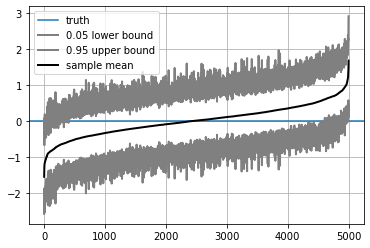

In [15]:
generate_CI(Neff_bretherton)

---
## variance estimate


- $\hat\sigma_0$ is unbiased if the time series is uncorrelated.
- if the timeseries is autocorrelated, the variance needs to be rescaled in order to be unbiased (Bailey and Hammersley 1946, eq 10):

$
\begin{align}
\big \langle \hat\sigma_0 \big \rangle &= \frac{1}{N-1} \sum_n \big \langle ( u_n - \hat \mu )^2 \big \rangle, \\
&= \frac{1}{N-1} \sum_n \big \langle ( u_n - \mu + \mu - \hat \mu )^2 \big \rangle, \\
&= \frac{1}{N-1} \sum_n \big \langle ( u_n - \mu )^2 \big \rangle -  \frac{N}{N-1}  \big \langle (\mu - \hat \mu )^2 \big \rangle, \\
&= \frac{N}{N-1} \big [  \sigma_0 - Var(\hat\mu) \big ], \\
&= \frac{N(N_e-1)}{(N-1)N_e} \sigma_0
\end{align}
$

- Note however that there is not such bias if the timeseries is not autocorrelated ($N=N_e$) and that the bias may be considerably reduced if the true mean $\mu$ is known (bias of order $\sigma_0/(N-1)$) or if the time series is long enough $N_e\gg1$.

- the variance of the sample variance has a complex expression (see eq. 13 from Bailey and Hammersley). A concept of effective degrees of freedom (different than for the sample average) may be employed, e.g. such that $Var(\hat \sigma_0) = 2\sigma_0^2 / (N_{e, \sigma} - 1)$. For long time series (Bailey and Hammersley):

$
\begin{align}
N_{e, \sigma} = \frac{N}{\sum_n \sigma^2(n) / \sigma_0^2 } 
\end{align}
$

- For normal uncorrelated timeseries, the variance is the sum of the square of normally distributed random variables and the following variable is distributed as a chi square distribution with $N$ degrees of freedom: 

$
\begin{align}
(N_e - 1) \hat \sigma_0 / \sigma_0 \sim \chi^2_{Ne-1}
\end{align}
$

- The variance of $\chi^2_{Ne-1}$ is $2(N_e-1)$ and, for normal uncorrelated timeseries, the variance of $\hat \sigma_0$ is thus: $2\sigma_0^2/(N_e-1)$



The average of the sample variance  is systematically lower than the true variance if the autocorrelation factor is not included:

In [16]:
float(ds.sigma0_hat.mean() /sigma_correction)

0.7847885516931948

This is an effect of the autocorrelated nature of the data and small temporal window which produces a systematically lower value of the standard deviation if the effective degrees of freedom is too small (e.g. 10% error for 10 points).

Bailey and Hammersley propose a correction that depends on the effective degrees of freedom (equation 10)

In [17]:
float(ds.sigma0_hat.mean())

0.9558672830140101

### Distribution of the sample variance

For normal uncorrelated timeseries, the variance is the sum of the square of normally distributed random variables and the following variable is distributed as a chi square distribution with $N$ degrees of freedom: 

$
\begin{align}
(N_e - 1) \hat \sigma_0 / \sigma_0 \sim \chi^2_{Ne-1}
\end{align}
$

The chi square prediction of the variance distribution is wider what is actually observed. \
**Is the adaptation of the chi2 distribution to the case of an autocorrelated time series wrong?**

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


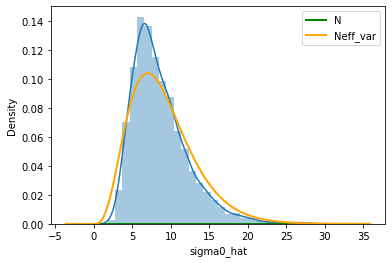

In [18]:
ax = sns.distplot(ds.sigma0_hat*(Neff_var-1)/sigma0, bins=30, norm_hist=True)

def add_dist(Neff, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = stats.chi2.pdf(x_pdf, Neff-1, loc=0, scale=1)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

add_dist(N, "N", "green")
add_dist(Neff_var, "Neff_var", "orange")
#add_dist(Neff_exact, "Neff_exact", "red")
#add_dist(Neff_bh, "Neff_bailey", "red")
#add_dist(Neff_bretherton, "Neff_bretherton", "brown")
    
ax.legend()
#ax.set_ylim(0, 1.)

### confidence interval

For a normally distributed input variable $u$:

$
\begin{align}
(N_e - 1) \hat \sigma_0 / \sigma_0 \sim \chi^2_{Ne-1}
\end{align}
$

which provides an estimate for confidence intervals:

$
\begin{align}
(N_e - 1) \hat \sigma_0 /q_{1-\alpha/2} < \sigma_0 < (N_e - 1) \hat \sigma_0 /q_{\alpha/2}
\end{align}
$

where $q_{\alpha}$ is the $\alpha$ percentile of the chi square distribution with $N_e-1$ degrees of freedom.


In [19]:
def generate_CI(Ne, alpha=0.1):

    ds["sigma0_lower"] = (Ne-1)*ds.sigma0_hat/stats.chi2.ppf(1-alpha/2, Ne-1)
    ds["sigma0_upper"] = (Ne-1)*ds.sigma0_hat/stats.chi2.ppf(alpha/2, Ne-1)

    _ds = ds.sortby("sigma0_hat")

    fig, ax = plt.subplots(1,1)

    # not working ... ?
    #ax.fill_between(_ds.mu_lower.values, _ds.mu_upper.values)
    #ax.fill_between(_ds.mu_upper.values, _ds.mu_lower.values)

    ax.plot(_ds.sigma0_lower, "0.5", lw=2)
    ax.plot(_ds.sigma0_upper, "0.5", lw=2)

    ax.plot(_ds.sigma0_hat, "k", lw=2)
    ax.grid()

    percent_success = (_ds.where( (_ds.sigma0_upper>sigma0) & (_ds.sigma0_lower<sigma0), drop=True )
                       .draw.size
                       /_ds.draw.size
                      )
    
    print(f"percent success = {percent_success:.2f}")

There is 6% offset in the expected success rate.

**Is this is due to statistical noise? or the fact that the fact that the variance does not satisfy a chi square distribution when the timeseries is autocorrelated?**

percent success = 0.96


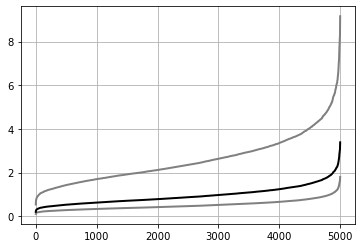

In [20]:
generate_CI(Neff_var)

Normalized confidence interval as a function of the effective degrees of freedom:

In [21]:
alpha = .1
ds_Ne = xr.Dataset(coords=dict(Ne=("Ne", np.arange(3,50))))
ds_Ne["var_lower"] = (ds_Ne.Ne-1)/stats.chi2.ppf(1-alpha/2, ds_Ne.Ne-1)
ds_Ne["var_upper"] = (ds_Ne.Ne-1)/stats.chi2.ppf(alpha/2, ds_Ne.Ne-1)

(0.0, 5.0)

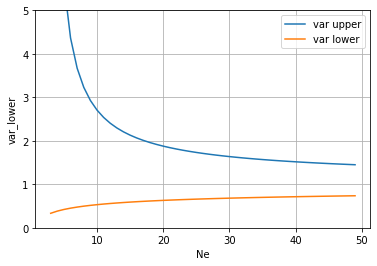

In [22]:
fig, ax = plt.subplots(1,1)
ds_Ne.var_upper.plot(ax=ax, label="var upper")
ds_Ne.var_lower.plot(ax=ax, label="var lower")
ax.legend()
ax.grid()
ax.set_ylim(0,5)

So 10 effective data points are not enough to constrain the variance by a factor 2 (at a 90% level). \
But 20 effective data points are.

What law do these confidence interval satisfy as a function of the effective degrees of freedom?

(0.1, 20)

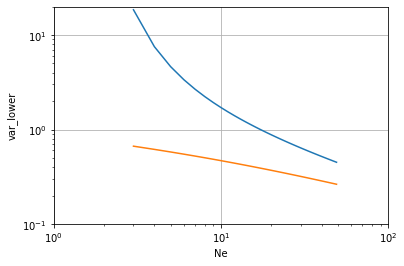

In [23]:
upper = ds_Ne.var_upper
lower = ds_Ne.var_lower

fig, ax = plt.subplots(1,1)
(upper - 1).plot(xscale="log", yscale="log")
(1 - lower).plot(xscale="log", yscale="log")
ax.grid()
ax.set_xlim(1,100)
ax.set_ylim(.1,20)